In [1]:
# @TODO: try this for y-values
# sometimes this is called “non-parametric” in classical statistics
# rank-based /percentile cutoff

In [173]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
                            accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_curve, 
                            roc_auc_score, 
                            confusion_matrix
                            )
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix

from unbalanced_dataset import OverSampler, SMOTE

import matplotlib.pyplot as plt
# import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR, ARResults
from scipy.misc import factorial as fact

%matplotlib inline

In [174]:
CONFIG = {}

with open('config.txt', "r") as in_file:
    for line in in_file:
        line = line.split(":")
        parameter = line[0].strip()
        value = line[1].strip()
        CONFIG[parameter] = value
                
engine_path = 'postgresql://'+CONFIG['username']+':'+\
                CONFIG['password']+'@'+CONFIG['ip']+\
                ':'+CONFIG['port']+'/'+CONFIG['database']
        
engine = create_engine(engine_path)

##Want something like:

In [7]:
def makeSQLQuery(table_names, year, seriesnames):
    dotyyear = '.y' + str(year)
    short = table_names[0][0:2]
    seriesnames = seriesnames
    abb = [ser[0:2] for ser in seriesnames]
    query = 'SELECT x.*, y' + dotyyear + ' as zscores FROM (' + \
            'SELECT ' + short + '.countrycode AS countrycode, ' + \
            short + dotyyear + ' AS ' + table_names[0] 
    
    mystr = ''
    for s in seriesnames:
        mystr = mystr + ', env.' + s
    mystr = mystr
    
    query = query + mystr
    
    query = query + ' FROM (SELECT countrycode, ' + dotyyear[1:] + \
        ' FROM ' + table_names[0] + ') ' + short + ' JOIN ' + \
        '(SELECT ' + abb[0] + '.countrycode AS countrycode'
    
    mystr = ''
    for a, ser in zip(abb, seriesnames):
        mystr = mystr + ', ' + a + dotyyear + ' as ' + ser
    query = query + mystr
    
    query = query + ' FROM ('
    
    subquery = []
    for a, ser in zip(abb, seriesnames):
        mystr = ''
        mystr = mystr + '(SELECT countrycode, ' + dotyyear[1:] + \
        ' FROM ' + table_names[1] + " WHERE series='" + ser + \
        "') " + a
        subquery.append(mystr)
    
    query = query + subquery[0] + ' JOIN ' + subquery[1] + ' ON ' + \
        abb[0] + '.countrycode = ' + abb[1] + '.countrycode' + \
        ' JOIN ' + subquery[2] + ' ON ' + \
        abb[0] + '.countrycode = ' + abb[2] + '.countrycode' + \
        ' JOIN ' + subquery[3] + ' ON ' + \
        abb[0] + '.countrycode = ' + abb[3] + '.countrycode)) env' + \
        ' ON ' + short + '.countrycode = env.countrycode'
        
    query = query + ') x JOIN (select countrycode, ' + dotyyear[1:] + \
            ' FROM refugee_increases_z_scores) y on x.countrycode = y.countrycode'
    
    return query

In [8]:
years = [x for x in range(2006, 2014)]

In [9]:
tables = ['forestarea', 'environment']
features = ['precipitation', 'extreme', 'arable_land', 'freshwater']
print makeSQLQuery(tables, years[0], features)

SELECT x.*, y.y2006 as zscores FROM (SELECT fo.countrycode AS countrycode, fo.y2006 AS forestarea, env.precipitation, env.extreme, env.arable_land, env.freshwater FROM (SELECT countrycode, y2006 FROM forestarea) fo JOIN (SELECT pr.countrycode AS countrycode, pr.y2006 as precipitation, ex.y2006 as extreme, ar.y2006 as arable_land, fr.y2006 as freshwater FROM ((SELECT countrycode, y2006 FROM environment WHERE series='precipitation') pr JOIN (SELECT countrycode, y2006 FROM environment WHERE series='extreme') ex ON pr.countrycode = ex.countrycode JOIN (SELECT countrycode, y2006 FROM environment WHERE series='arable_land') ar ON pr.countrycode = ar.countrycode JOIN (SELECT countrycode, y2006 FROM environment WHERE series='freshwater') fr ON pr.countrycode = fr.countrycode)) env ON fo.countrycode = env.countrycode) x JOIN (select countrycode, y2006 FROM refugee_increases_z_scores) y on x.countrycode = y.countrycode


In [23]:
df = pd.DataFrame()

In [24]:
for year in years:
    query = makeSQLQuery(tables, year, features)
    year_data = pd.read_sql_query(query, engine)
    year_data['year'] = year
    year_data = year_data.set_index(['countrycode', 'year'])
    df = pd.concat([df, year_data])

In [25]:
len(df)

1264

In [26]:
df = df.dropna()

In [15]:
df['zscores'] = df['zscores'].astype(float)

In [17]:
df.describe()

,forestarea,precipitation,extreme,arable_land,freshwater,zscores
count,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000
mean,30.765481,1117.474684,1.202044,16.082192,14745.413957,-0.046499
std,22.101938,757.163111,1.970723,13.834087,34871.282499,0.251866
min,0.067909,51.000000,0.000000,0.051769,0.000000,-0.082345
25%,11.112776,564.250000,0.022191,5.182952,1164.644805,-0.082345
50%,30.811820,1010.000000,0.266991,11.934412,2991.640584,-0.082345
75%,46.710563,1608.500000,1.295973,22.807534,11832.114071,-0.079950
max,98.506410,3240.000000,9.226586,60.536222,323213.140961,5.172378


In [39]:
df['binary'] = df['zscores'].apply(lambda x: 0 if x<0 else 1)

In [19]:
len(df[df['binary']==1])

60

In [20]:
len(df)

1264

In [22]:
60./1264*100

4.746835443037975

In [42]:
df.describe()

,forestarea,precipitation,extreme,arable_land,freshwater,zscores,binary
count,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000
mean,30.606953,1112.219025,1.214430,16.109750,14878.542330,0.040514,0.157474
std,22.133838,757.134960,1.976777,13.874216,35020.530613,1.143605,0.364320
min,0.067909,51.000000,0.000000,0.051769,0.000000,-0.293136,0.000000
25%,11.078235,562.000000,0.023082,5.127726,1147.784317,-0.276353,0.000000
50%,30.513576,1010.000000,0.269239,11.936709,3063.458600,-0.262625,0.000000
75%,46.556322,1604.000000,1.295973,22.676412,12391.666391,-0.197219,0.000000
max,98.506410,3240.000000,9.226586,60.536222,323213.140961,9.868634,1.000000


In [28]:
df = df.swaplevel(0, 1, axis=0)

In [150]:
df.head()

forestarea  precipitation   extreme  arable_land  \
year countrycode                                                     
2006 ARG           10.913914            591  0.167190    12.735823   
     AUS           16.499616            534  3.047099     6.211031   
     BRA           60.429569           1761  0.482451     8.319794   
     CHN           20.723562            645  7.950971    11.578350   
     FRA           29.172541            867  0.005718    33.490456   

                    freshwater  zscores  
year countrycode                         
2006 ARG           7305.496838        0  
     AUS          23622.500912        0  
     BRA          29364.390723        0  
     CHN           2134.480626        0  
     FRA           3124.207769        0

In [29]:
x_cols = ['forestarea', 'precipitation', 'extreme', 'arable_land', 'freshwater']

In [30]:
# convert each feature to z-score to normalize
for col in x_cols:
    df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)

In [33]:
def getScoreValues(X_train, 
                   X_test, 
                   y_train, 
                   y_test, 
                   model
                  ):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy_score_value = accuracy_score(y_test, y_pred)
    precision_score_value = precision_score(y_test, y_pred)
    recall_score_value = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred) 
    
    scores = pd.Series(data=[accuracy_score_value, precision_score_value, recall_score_value, f1_score_value],
                      index=["Accuracy", "Precision", "Recall", "F1"])
    
    return scores

In [34]:
def getFeatureImportance(X_train, 
                   X_test, 
                   y_train, 
                   y_test, 
                   model, 
                   verbose=True, 
                   get_features=True
                  ):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        feature_importances = model.feature_importances_
        #print(feature_importances)
    except AttributeError:
        pass
    fimp = pd.Series(data=feature_importances, index=x_cols)
    return fimp

In [43]:
test = np.arange(min(years)+1, max(years))
train = []
for y in test:
    tr = [yr for yr in years if yr<y]
    train.append(tr)
    print tr, y
    
training_sets = []
test_sets = []
for prev, year in zip(train, test):
    test_sets.append(df.xs(year, level='year', axis=0))
    
    for year in test:
        trainyear = pd.DataFrame()
        for y in prev:
            data = df.xs(y, level='year', axis=0)
            trainyear = pd.concat([trainyear, data])
    
    training_sets.append(trainyear)

[2006] 2007
[2006, 2007] 2008
[2006, 2007, 2008] 2009
[2006, 2007, 2008, 2009] 2010
[2006, 2007, 2008, 2009, 2010] 2011
[2006, 2007, 2008, 2009, 2010, 2011] 2012


In [58]:
def score_model(train, test, model):
    year = 2007
    dfscores = pd.DataFrame()
    for train, test in zip(train, test):
        X_train, X_test, y_train, y_test = train[x_cols], test[x_cols], train['binary'], test['binary']
        scores = getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())
        dfscores = dfscores.append(scores, ignore_index=True)
        year += 1
    avgscores = [(s, dfscores[s].mean()) for s in dfscores]
    totscores = pd.Series([dfscores[s].mean() for s in dfscores], index=[s for s in dfscores])
    print totscores
#     return totscores

In [44]:
score_model(training_sets, test_sets, DecisionTreeClassifier())

[('Accuracy', 0.9525316455696201), ('F1', 0.5175472675472675), ('Precision', 0.560978835978836), ('Recall', 0.5791666666666667)]


In [48]:
getFeatureImportance(training_sets[5][x_cols], test_sets[5][x_cols], training_sets[5]['binary'], test_sets[5]['binary'], DecisionTreeClassifier())

forestarea       0.280209
precipitation    0.013201
extreme          0.152844
arable_land      0.332709
freshwater       0.221036
dtype: float64

In [49]:
smallxcols = ['forestarea', 'freshwater', 'arable_land', 'extreme']

In [120]:
models = [DecisionTreeClassifier(), BernoulliNB(), GaussianNB(), 
          SVC(probability=True), RandomForestClassifier(), KNeighborsClassifier()]

In [53]:
modelnames = ["Decision Tree", "Bernoulli NB", "Gaussian NB", "SVM", "Random Forest", "K Neighbors"]

In [59]:
def score_model(train, test, model):
    year = 2007
    dfscores = pd.DataFrame()
    for train, test in zip(train, test):
        X_train, X_test, y_train, y_test = train[smallxcols], test[smallxcols], train['binary'], test['binary']
        scores = getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())
        dfscores = dfscores.append(scores, ignore_index=True)
        year += 1
    avgscores = [(s, dfscores[s].mean()) for s in dfscores]
    totscores = pd.Series([dfscores[s].mean() for s in dfscores], index=[s for s in dfscores])
    print totscores
#     return totscores

In [63]:
dfmodelscores = pd.DataFrame(index=["Accuracy", "Precision", "Recall", "F1"], columns=modelnames)
for model, name in zip(models, modelnames):
    print name
    print model
    print score_model(training_sets, test_sets, model)

Decision Tree
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
Accuracy     0.949367
F1           0.460140
Precision    0.490741
Recall       0.516667
dtype: float64
None
Bernoulli NB
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Accuracy     0.948312
F1           0.467716
Precision    0.532407
Recall       0.516667
dtype: float64
None
Gaussian NB
GaussianNB()
Accuracy     0.949367
F1           0.480342
Precision    0.520503
Recall       0.537500
dtype: float64
None
SVM
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Accuracy     0.951477
F1           0.505012
Precision    0.532407
Recall       0.558333
dtype: float6

In [65]:
for n in range(1, 10):
    model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=n, p=2, weights='uniform')
    print "N: " + str(n)
    print score_model(training_sets, test_sets, model)
    print "==="

N: 1
Accuracy     0.948312
F1           0.460140
Precision    0.490741
Recall       0.516667
dtype: float64
None
===
N: 2
Accuracy     0.949367
F1           0.487918
Precision    0.532407
Recall       0.537500
dtype: float64
None
===
N: 3
Accuracy     0.950422
F1           0.488278
Precision    0.492725
Recall       0.558333
dtype: float64
None
===
N: 4
Accuracy     0.948312
F1           0.488278
Precision    0.492725
Recall       0.558333
dtype: float64
None
===
N: 5
Accuracy     0.950422
F1           0.505012
Precision    0.532407
Recall       0.558333
dtype: float64
None
===
N: 6
Accuracy     0.948312
F1           0.467716
Precision    0.532407
Recall       0.516667
dtype: float64
None
===
N: 7
Accuracy     0.950422
F1           0.505012
Precision    0.532407
Recall       0.558333
dtype: float64
None
===
N: 8
Accuracy     0.951477
F1           0.487918
Precision    0.532407
Recall       0.537500
dtype: float64
None
===
N: 9
Accuracy     0.948312
F1           0.471795
Precision    0.

In [92]:
def getROCcurve(X_train, X_test, y_train, y_test, model):
    model = model
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    auc = roc_auc_score(y_test, y_scores)
#     print('AUC: {}'.format(auc))
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='AUC: %0.3f' % auc, color='#0431B4')
    ax.fill_between(fpr, tpr, 0, facecolor='#0431B4')

    fig.set_size_inches(12, 8, forward=True)
    plt.xlabel('False Postive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('KNN (k=5) ROC Curve for Climate-Triggered Refugee Disasters', fontsize=20)
    plt.legend(loc='best', fontsize=14)

In [67]:
test2013 = df.xs(2013, level='year', axis=0)

In [68]:
train2013 = pd.concat([training_sets[5], df.xs(2012, level='year', axis=0)])

In [71]:
X_trainfinal, X_testfinal, y_trainfinal, y_testfinal = train2013[x_cols], test2013[x_cols], train2013['binary'], test2013['binary']

In [72]:
getScoreValues(X_trainfinal, X_testfinal, y_trainfinal, y_testfinal, KNeighborsClassifier(n_neighbors=5))

Accuracy     0.949367
Precision    0.500000
Recall       0.250000
F1           0.333333
dtype: float64

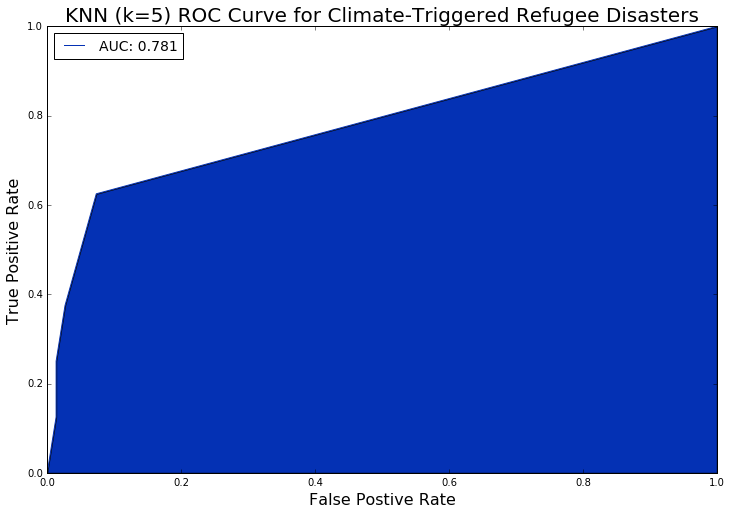

In [93]:
getROCcurve(X_trainfinal, X_testfinal, y_trainfinal, y_testfinal, KNeighborsClassifier(n_neighbors=5))

In [157]:
def getROCcurveMulti(X_train, X_test, y_train, y_test, models):
    colors = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   
    for x in range(len(colors)):    
        r, g, b = colors[x]    
        colors[x] = (r / 255., g / 255., b / 255.)
        
    fig,ax = plt.subplots()
    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left() 
    plt.yticks(fontsize=14)    
    plt.xticks(fontsize=14)
    
    for y in range(0, 101, 20):    
        plt.plot([x/100. for x in range(0, 100)], [y/100.] * len(range(0, 100)), lw=0.5, color="black", alpha=0.3) 
    plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on") 
    
    for i, m in enumerate(models):
        model = m
        model.fit(X_train, y_train)
        y_scores = model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)

        auc = roc_auc_score(y_test, y_scores)
        plt.plot(fpr, tpr, label=str(model).split('(')[0]+': %0.3f' % auc, color=colors[i*9%20], lw=2.5)

    fig.set_size_inches(12, 8, forward=True)
    plt.xlabel('False Postive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('ROC Curves for Climate-Triggered Refugee Disasters', fontsize=30)
    plt.legend(loc='best', fontsize=14)

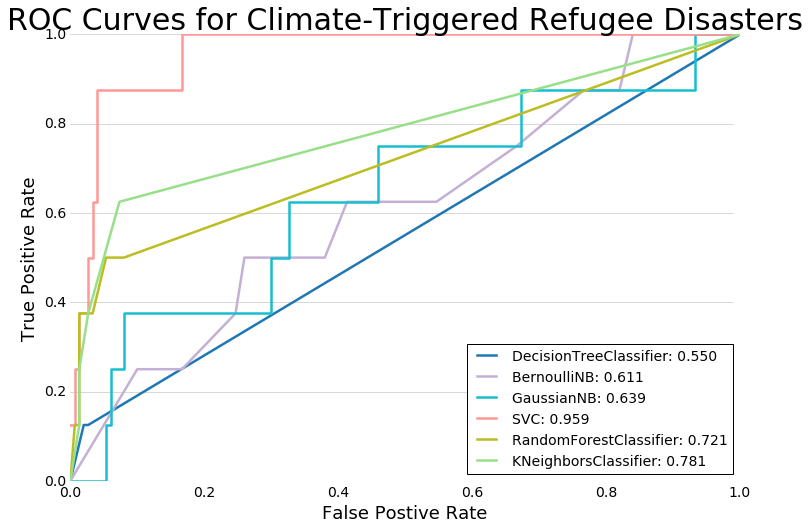

In [158]:
getROCcurveMulti(X_trainfinal, X_testfinal, y_trainfinal, y_testfinal, models)

In [161]:
model.fit(X_trainfinal, y_trainfinal)
y_pred = model.predict(X_testfinal)

In [170]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Crisis', 'Crisis'], rotation=35, fontsize=14)
    plt.yticks(tick_marks, ['No Crisis', 'Crisis'], fontsize=14)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

Confusion matrix, without normalization
[[148   2]
 [  6   2]]


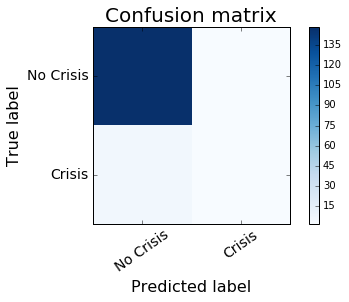

In [171]:
cm = confusion_matrix(y_testfinal, y_pred, labels=None)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

In [176]:
len(y_pred)

158

In [191]:
y_testfinal.index

Index([   u'ARG',    u'AUS',    u'BRA',    u'CHN',    u'FRA',    u'DEU',
          u'IND',    u'IDN',    u'ITA',    u'JPN',
       ...
          u'TTO',    u'TUN',    u'UGA',    u'URY',    u'UZB',    u'VEN',
          u'VNM',    u'YEM',    u'ZMB', u'y_pred'],
      dtype='object', name=u'countrycode', length=159)

In [180]:
len(y_testfinal)

158

In [192]:
predictions = pd.DataFrame({'y_testfinal':y_testfinal, 'y_pred':y_pred}, index=y_testfinal.index[:-1])

In [194]:
predictions[predictions['y_pred']!=predictions['y_testfinal']]

,y_pred,y_testfinal
countrycode,,
ALB,0,1
EST,0,1
LTU,0,1
MDG,0,1
MDV,1,0
MDA,0,1
PRI,0,1
ROM,1,0
